In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM


In [2]:
start = dt.datetime(2014,1,1)
end = dt.datetime(2022,1,1)

yf.pdr_override()
stock = input('Enter a stock ticker symbol : ')

data = pdr.get_data_yahoo(stock, start, end)

[*********************100%***********************]  1 of 1 completed


In [3]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 90

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Epoch 1/100
31/31 [==============================] - 16s 349ms/step - loss: 0.0180
Epoch 2/100
31/31 [==============================] - 11s 344ms/step - loss: 0.0021
Epoch 3/100
31/31 [==============================] - 10s 332ms/step - loss: 0.0015
Epoch 4/100
31/31 [==============================] - 10s 324ms/step - loss: 0.0012
Epoch 5/100
31/31 [==============================] - 9s 286ms/step - loss: 0.0012
Epoch 6/100
31/31 [==============================] - 9s 281ms/step - loss: 0.0013
Epoch 7/100
31/31 [==============================] - 9s 291ms/step - loss: 0.0013
Epoch 8/100
31/31 [==============================] - 9s 290ms/step - loss: 0.0013
Epoch 9/100
31/31 [==============================] - 9s 300ms/step - loss: 0.0013
Epoch 10/100
31/31 [==============================] - 9s 293ms/step - loss: 0.0011
Epoch 11/100
31/31 [==============================] - 9s 291ms/step - loss: 0.0011
Epoch 12/100
31/31 [==============================] - 9s 287ms/step - loss: 0.0011
Epoch 13/

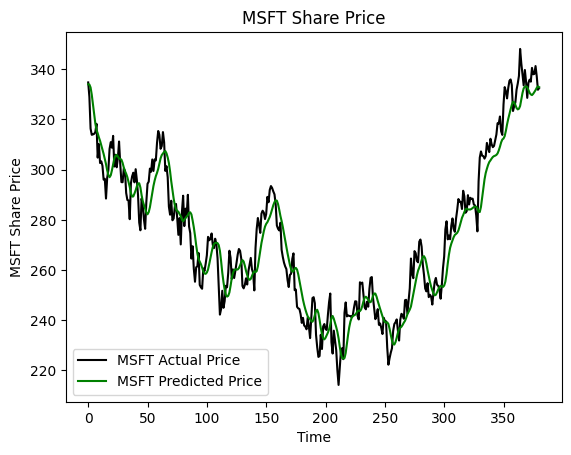

In [4]:
model = Sequential()

model.add(LSTM(units=100, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.27))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.27))
model.add(LSTM(units=100))
model.add(Dropout(0.27))
model.add(Dense(units=1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 100, batch_size = 64)

test_start = dt.datetime(2022,1,2)
test_end = dt.datetime.now()

datatest = pdr.get_data_yahoo(stock, test_start, test_end)

test_data = datatest
actual_prices = datatest['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

plt.plot(actual_prices, color = 'black', label = f'{stock} Actual Price')
plt.plot(predicted_prices, color = 'green', label = f'{stock} Predicted Price')
plt.title(f'{stock} Share Price')
plt.xlabel('Time')
plt.ylabel(f'{stock} Share Price')
plt.legend()
plt.show()

In [5]:
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs) + 1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)

current_time = dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
printstart = dt.datetime(2023, 1, 1)
printend = dt.datetime.now()
actual_closing = pdr.get_data_yahoo(stock, printstart, printend)
actual_closing_price = actual_closing['Close'][-1]


print(f'{stock} Predicted Closing Price ({current_time}): {prediction}')
print(f'{stock} Current Actual Closing Price ({current_time}): {actual_closing_price}')

1/1 [==============================] - 1s 1s/step
[*********************100%***********************]  1 of 1 completed
MSFT Predicted Closing Price (2023-07-11 16:28:10): [[332.08426]]
MSFT Current Actual Closing Price (2023-07-11 16:28:10): 332.4700012207031
